# Conditional Generation

![](conditional_gan.png)

@Img [ConditionalGAN paper](https://arxiv.org/abs/1411.1784)


In [3]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

**Plotting Images**

In [4]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28), nrow=5, show=True):
    
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show:
        plt.show()

## Generator

In [14]:
class Generator(nn.Module):
    '''
    Generator Class
    
    Values:
        input_dim: the dimension of the input vector, a scalar
        im_chan: the number of channels of the output image, a scalar (MNIST im_ch = 1)
        hidden_dim: the inner dimension, a scalar
    '''
    
    def __init__(self, input_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.input_dim = input_dim

        self.gen = nn.Sequential(
            self.make_gen_block(input_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, input_dim)
        '''
        x = noise.view(len(noise), self.input_dim, 1, 1)
        return self.gen(x)

# Noise from normal distribution for samples of input_dimension 
def get_noise(n_samples, input_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, input_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        input_dim: the dimension of the input vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, input_dim, device=device)

## Discriminator

In [15]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
      im_chan: the number of channels of the output image, a scalar
            (MNIST is black-and-white, so 1 channel is your default)
      hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=64):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of the DCGAN; 
        a convolution, a batchnorm (except in the final layer), and an activation (except in the final layer).
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_chan)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

#### One Hot Encoding

In [7]:
import torch.nn.functional as F

# One hot encoding of the labels
def get_one_hot_labels(labels, n_classes):
    '''
    Function for creating one-hot vectors for the labels, returns a tensor of shape (?, num_classes).
    Parameters:
        labels: tensor of labels from the dataloader, size (?)
        n_classes: the total number of classes in the dataset, an integer scalar
    '''
    return F.one_hot(labels,n_classes)

### Combine (Concatenate ) Two vectors

In [8]:
def combine_vectors(x, y):
    '''
    Function for combining two vectors with shapes (n_samples, ?) and (n_samples, ?).
    Parameters:
      x: (n_samples, ?) the first vector. 
        In this assignment, this will be the noise vector of shape (n_samples, z_dim), 
        but you shouldn't need to know the second dimension's size.
      y: (n_samples, ?) the second vector.
        Once again, in this assignment this will be the one-hot class vector 
        with the shape (n_samples, n_classes), but you shouldn't assume this in your code.
    '''
    # Note: Make sure this function outputs a float no matter what inputs it receives
    
    combined = torch.cat((x.float(),y.float()), 1)
    return combined

#### Parameters

In [23]:
mnist_shape = (1, 28, 28)
n_classes = 10
n_epochs = 50
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002
device = 'cuda'

### Image transformation and Data loader

In [24]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=False, transform=transform),
    batch_size=batch_size,
    shuffle=True)

#### Input dimension from Z-Dim, Img-Shape, and No. of Classes

In [25]:
def get_input_dimensions(z_dim, mnist_shape, n_classes):
    '''
    Function for getting the size of the conditional input dimensions 
    from z_dim, the image shape, and number of classes.
    Parameters:
        z_dim: the dimension of the noise vector, a scalar
        mnist_shape: the shape of each MNIST image as (C, W, H), which is (1, 28, 28)
        n_classes: the total number of classes in the dataset, an integer scalar
                (10 for MNIST)
    Returns: 
        generator_input_dim: the input dimensionality of the conditional generator, 
                          which takes the noise and class vectors
        discriminator_im_chan: the number of input channels to the discriminator
                            (e.g. C x 28 x 28 for MNIST)
    '''
    generator_input_dim = z_dim + n_classes
    discriminator_im_chan = mnist_shape[0] + n_classes

    return generator_input_dim, discriminator_im_chan

### Initialize Models, Weights and , Optimizers

In [26]:
generator_input_dim, discriminator_im_chan = get_input_dimensions(z_dim, mnist_shape, n_classes)

gen = Generator(input_dim=generator_input_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator(im_chan=discriminator_im_chan).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
        
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

Generating - Images .... 



Step 500: Generator loss: 1.6571758880615235, discriminator loss: 0.36521958726644516


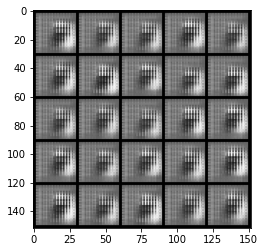

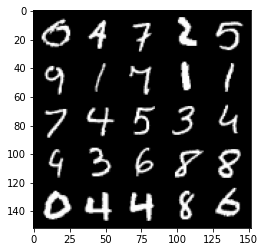

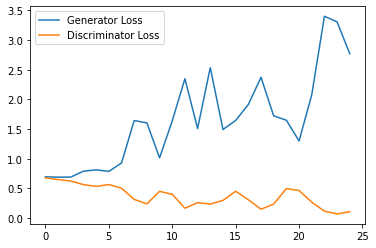

Step 1000: Generator loss: 2.993132224917412, discriminator loss: 0.18047017266228796


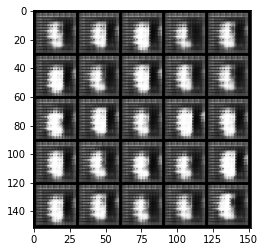

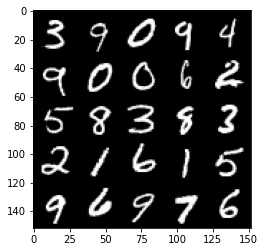

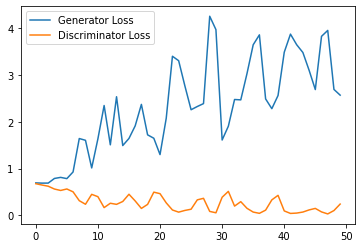

Step 1500: Generator loss: 3.6828513700962064, discriminator loss: 0.11335362168774009


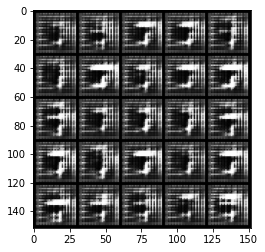

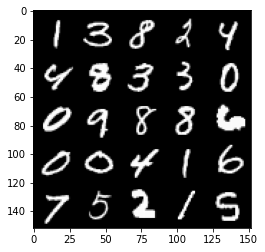

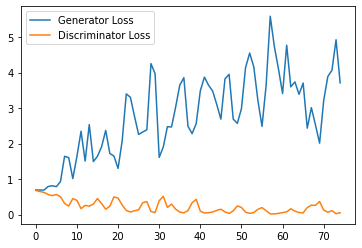

Step 2000: Generator loss: 3.387119734287262, discriminator loss: 0.10994958252459765


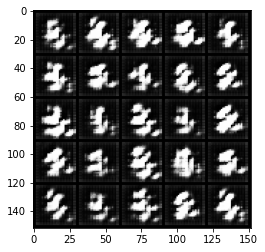

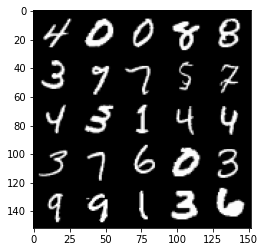

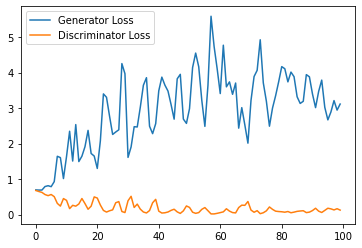

Step 2500: Generator loss: 3.1493752403259276, discriminator loss: 0.14996502056717873


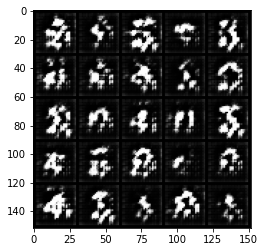

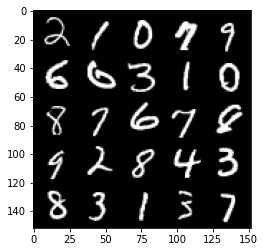

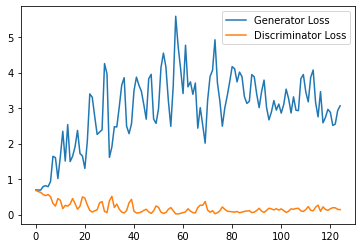

Step 3000: Generator loss: 2.3560491502285004, discriminator loss: 0.25592804883420467


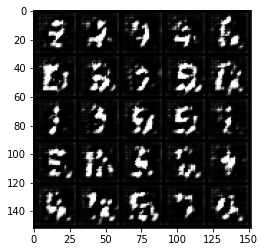

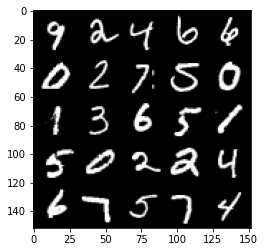

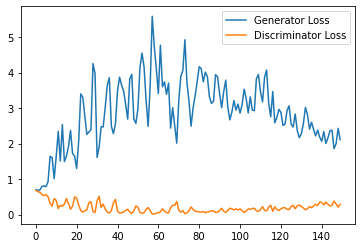

Step 3500: Generator loss: 2.061939024925232, discriminator loss: 0.30675532534718514


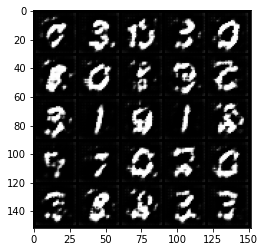

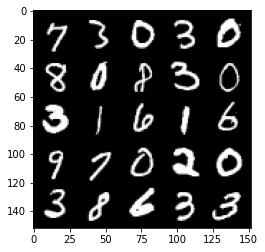

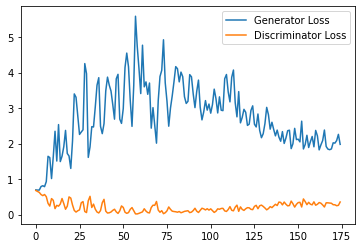

Step 4000: Generator loss: 2.2704857320785523, discriminator loss: 0.2965261700153351


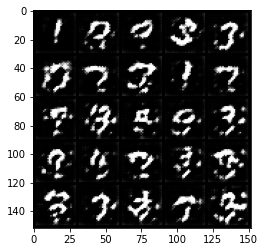

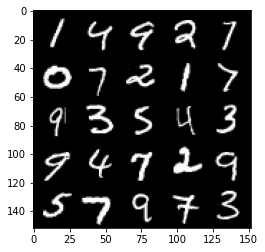

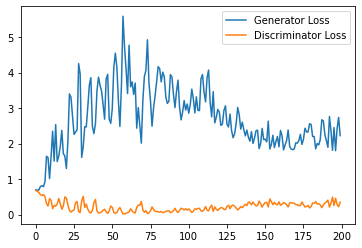

Step 4500: Generator loss: 2.06172526550293, discriminator loss: 0.3352901562154293


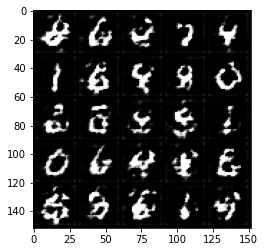

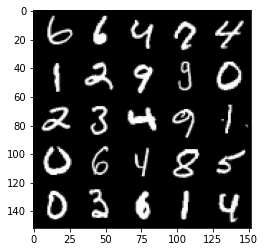

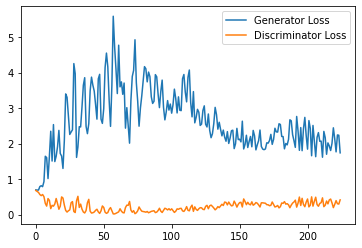

Step 5000: Generator loss: 1.9523720157146454, discriminator loss: 0.3498448338806629


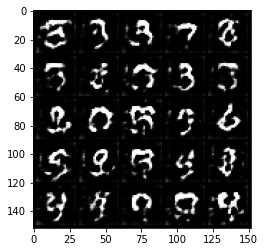

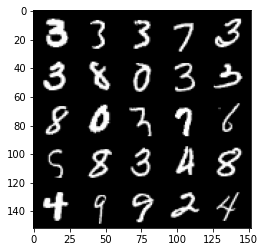

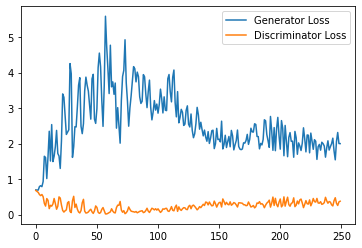

Step 5500: Generator loss: 1.8775175337791443, discriminator loss: 0.37335888674855233


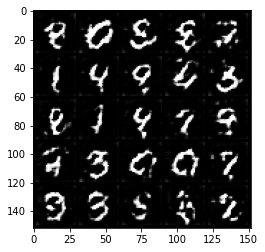

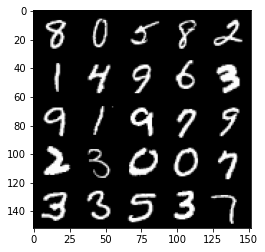

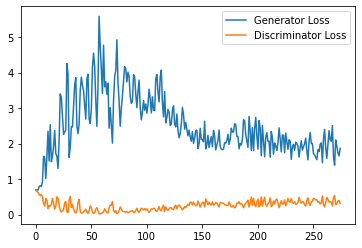

Step 6000: Generator loss: 1.8206784884929657, discriminator loss: 0.38070632964372636


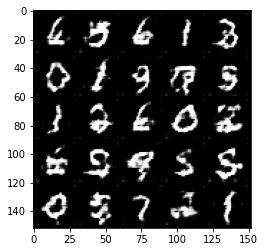

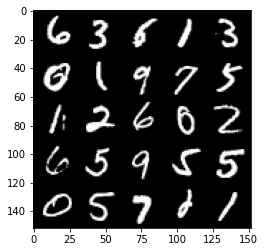

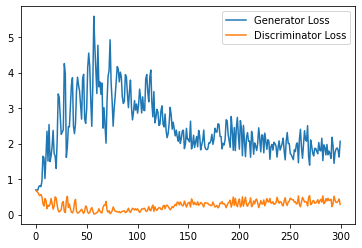

Step 6500: Generator loss: 1.6635424242019654, discriminator loss: 0.4084729571342468


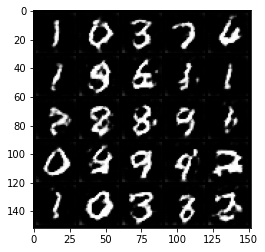

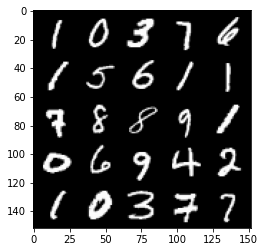

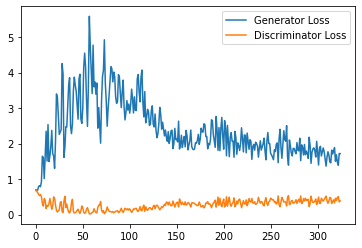

Step 7000: Generator loss: 1.5755623642206191, discriminator loss: 0.43332185977697374


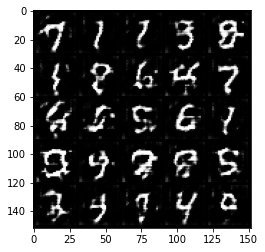

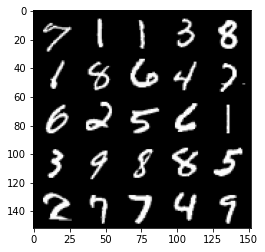

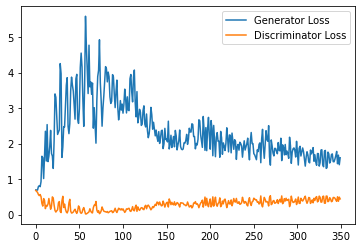

Step 7500: Generator loss: 1.6233736865520478, discriminator loss: 0.44802274137735365


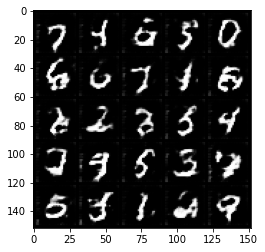

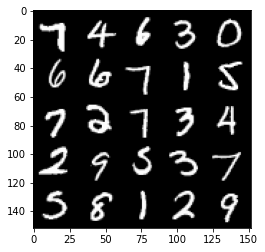

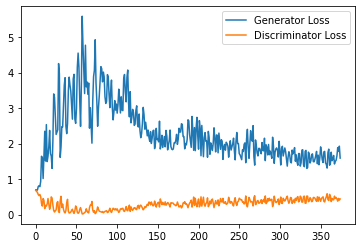

Step 8000: Generator loss: 1.6234189746379852, discriminator loss: 0.4564206686913967


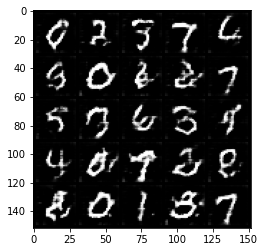

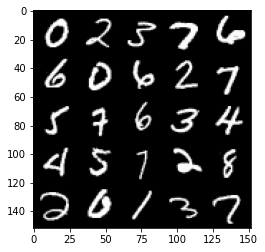

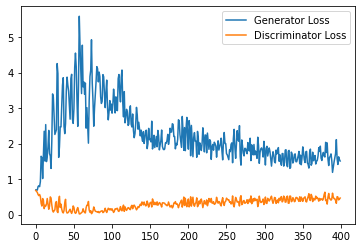

Step 8500: Generator loss: 1.417880131483078, discriminator loss: 0.4955559641122818


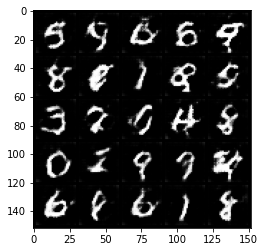

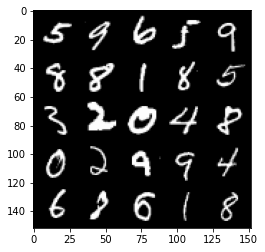

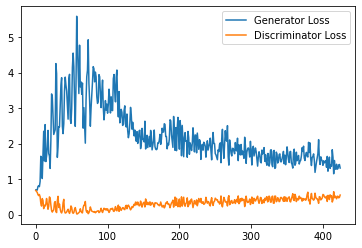

Step 9000: Generator loss: 1.3586220446825028, discriminator loss: 0.5152944485545159


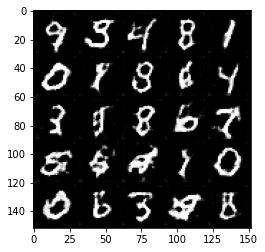

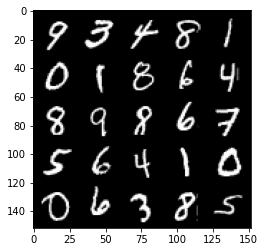

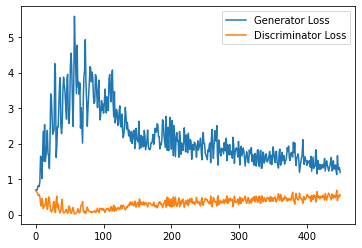

Step 9500: Generator loss: 1.2567750035524368, discriminator loss: 0.521695664703846


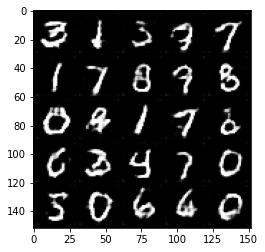

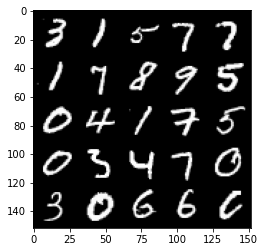

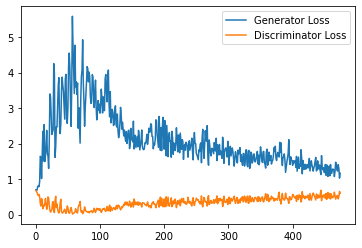

Step 10000: Generator loss: 1.271872262597084, discriminator loss: 0.5370621557235717


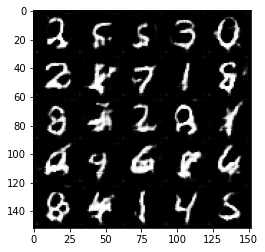

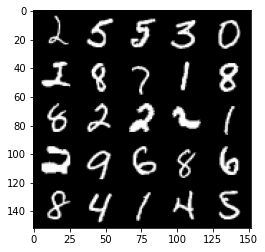

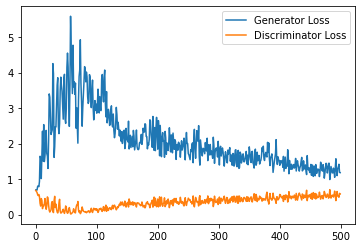

Step 10500: Generator loss: 1.1957927821874619, discriminator loss: 0.5465377546548843


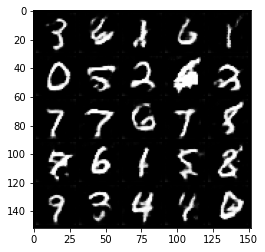

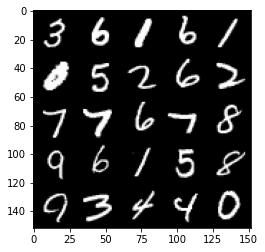

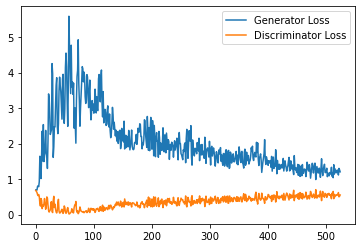

Step 11000: Generator loss: 1.2008436324596405, discriminator loss: 0.5430519118309021


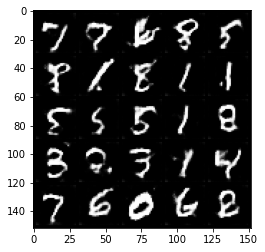

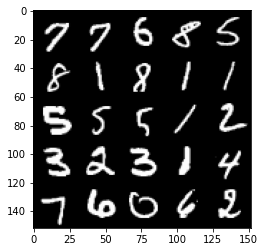

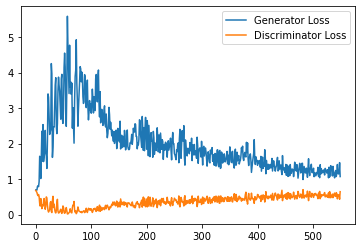

Step 11500: Generator loss: 1.200770850419998, discriminator loss: 0.5500126953125


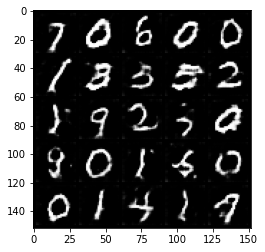

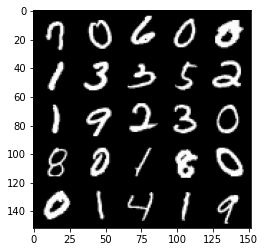

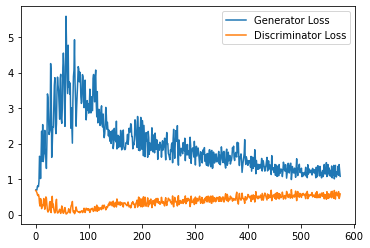

Step 12000: Generator loss: 1.1664893882274627, discriminator loss: 0.5458696637749672


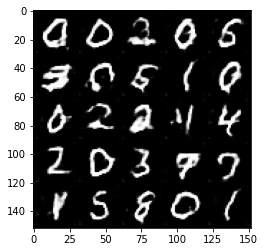

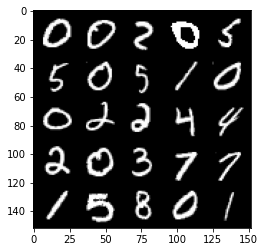

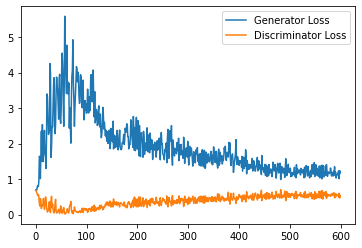

Step 12500: Generator loss: 1.0960834814310074, discriminator loss: 0.553050218641758


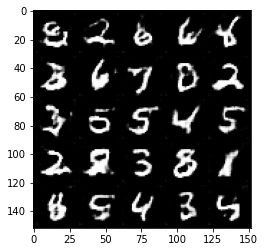

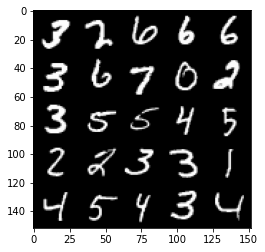

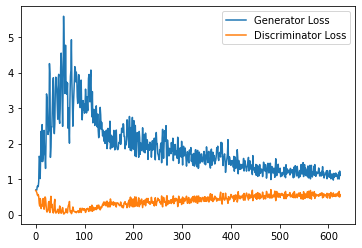

Step 13000: Generator loss: 1.1192569997310637, discriminator loss: 0.5630746206641197


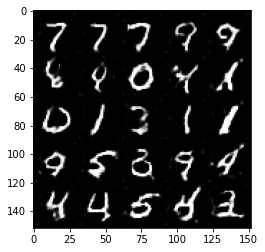

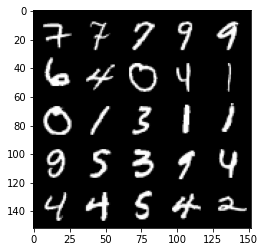

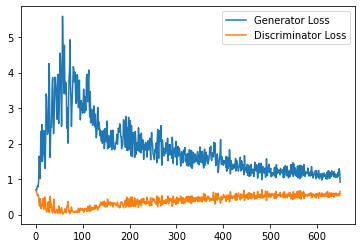

Step 13500: Generator loss: 1.0989846975803375, discriminator loss: 0.5616452569961548


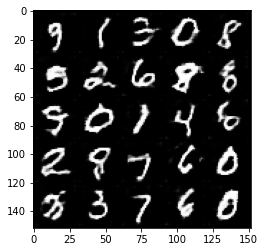

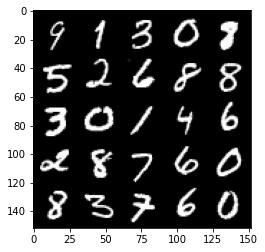

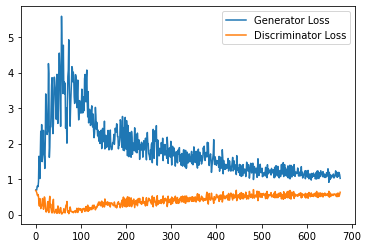

Step 14000: Generator loss: 1.1309259694814682, discriminator loss: 0.567383359849453


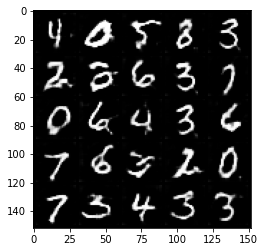

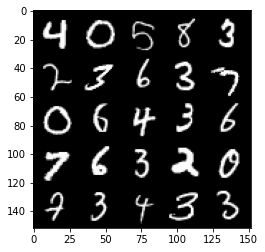

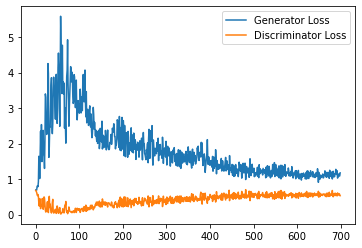

Step 14500: Generator loss: 1.122270603775978, discriminator loss: 0.5775462515950203


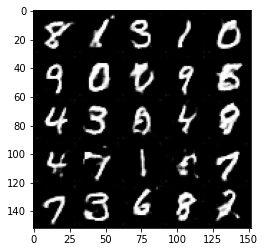

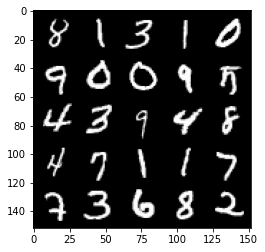

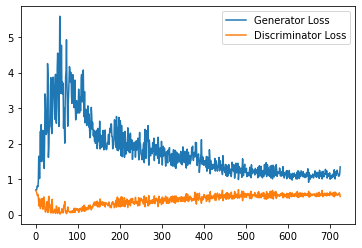

Step 15000: Generator loss: 1.090250188589096, discriminator loss: 0.5826427692770958


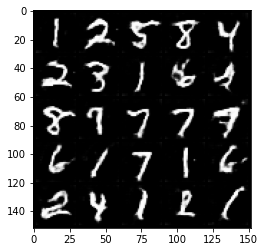

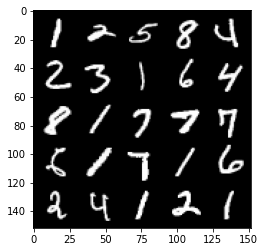

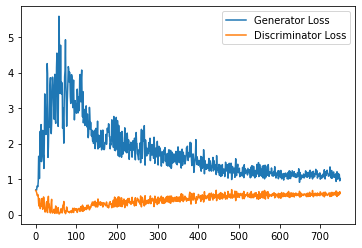

Step 15500: Generator loss: 1.0596226261854171, discriminator loss: 0.5824774417281151


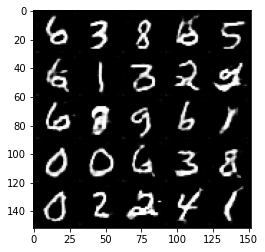

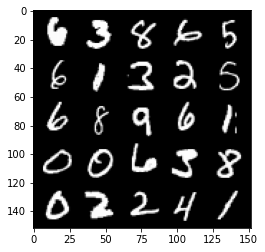

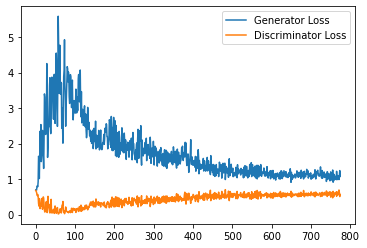

Step 16000: Generator loss: 1.0623313806056975, discriminator loss: 0.5864349786639214


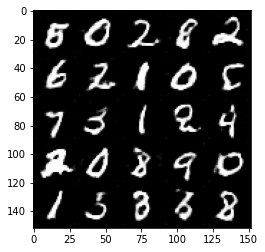

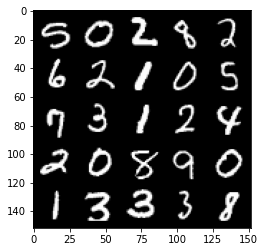

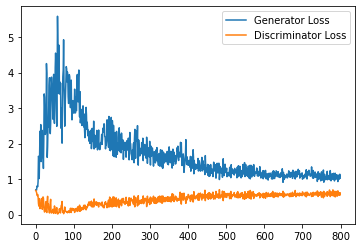

Step 16500: Generator loss: 1.0449137440919876, discriminator loss: 0.591586098074913


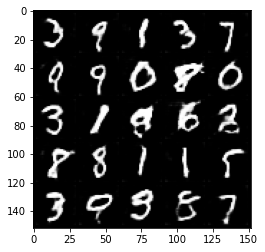

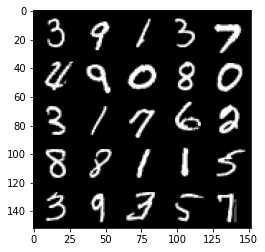

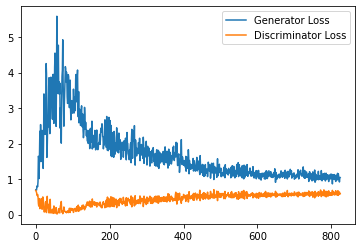

Step 17000: Generator loss: 1.0355077139139175, discriminator loss: 0.5934039627909661


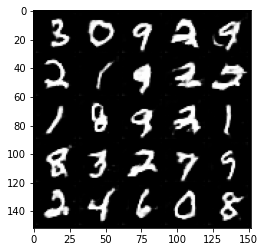

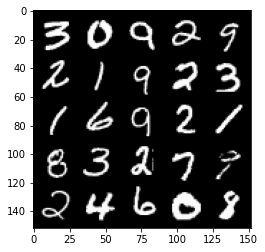

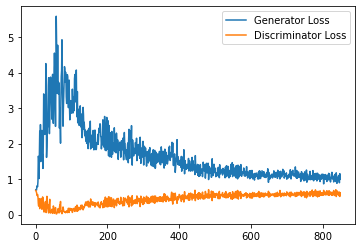

Step 17500: Generator loss: 0.9953488967418671, discriminator loss: 0.5957402731180191


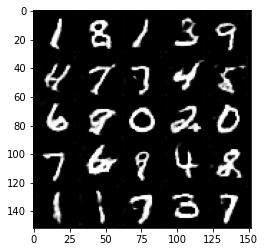

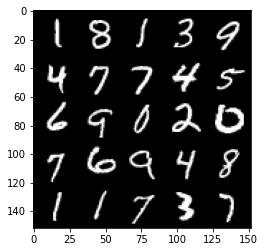

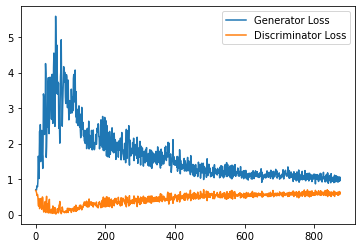

Step 18000: Generator loss: 1.033142195224762, discriminator loss: 0.5932998362183571


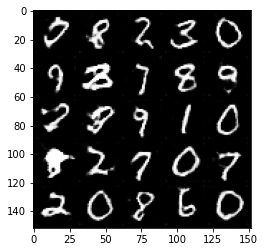

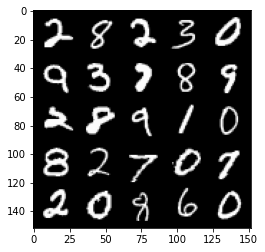

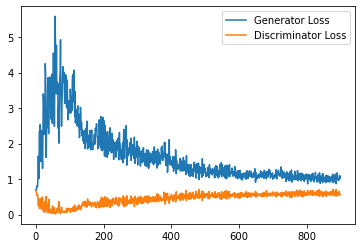

Step 18500: Generator loss: 1.0024686934947968, discriminator loss: 0.6045507899522782


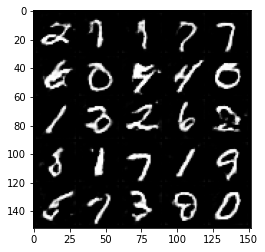

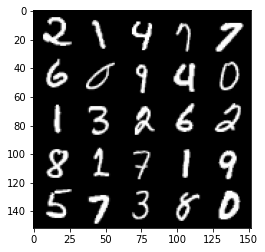

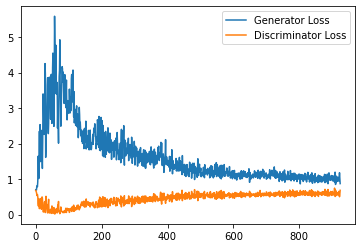

Step 19000: Generator loss: 1.028521075963974, discriminator loss: 0.5961186290383339


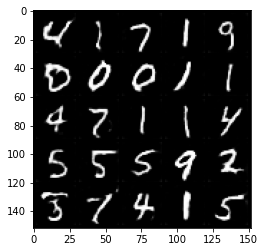

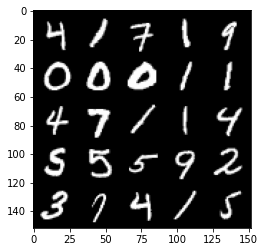

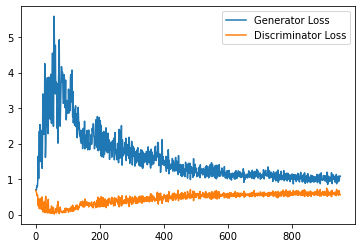

Step 19500: Generator loss: 0.9963653734922409, discriminator loss: 0.6062701717019081


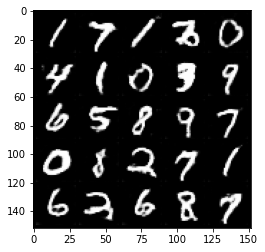

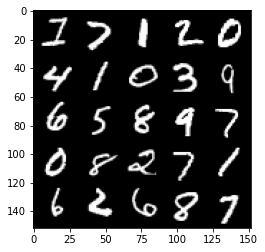

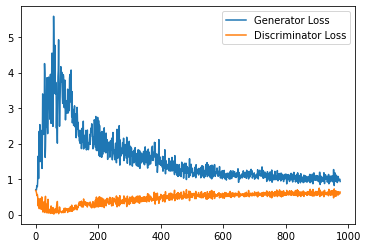

Step 20000: Generator loss: 0.9915916199684143, discriminator loss: 0.6049691100120544


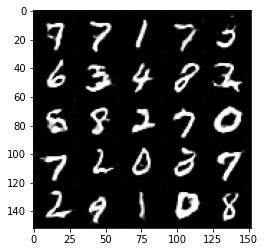

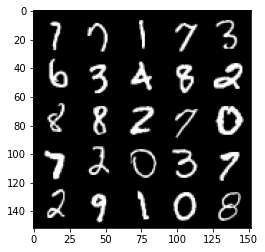

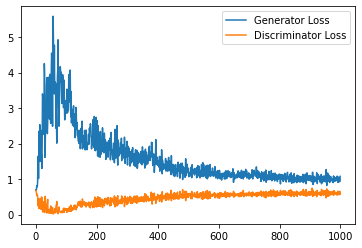

Step 20500: Generator loss: 0.9740227422714234, discriminator loss: 0.6121736593842506


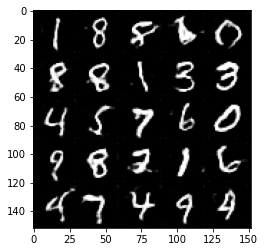

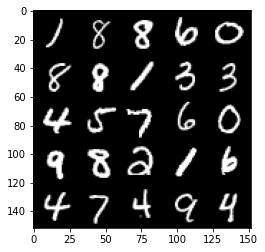

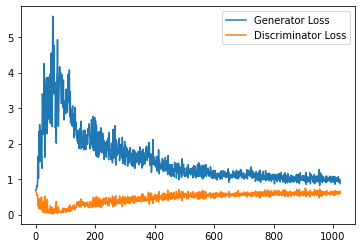

Step 21000: Generator loss: 0.9741170670986176, discriminator loss: 0.6110648053884506


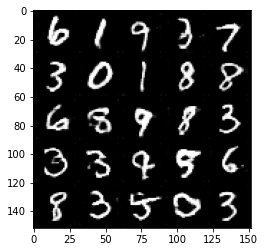

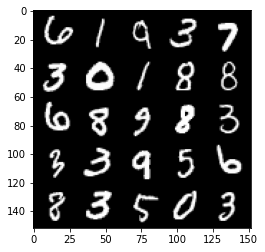

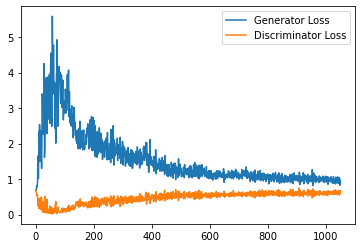

Step 21500: Generator loss: 0.9854770267009735, discriminator loss: 0.6128203559517861


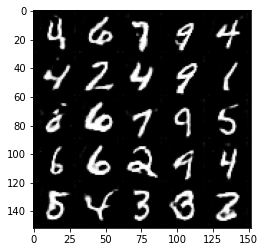

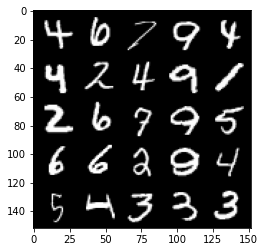

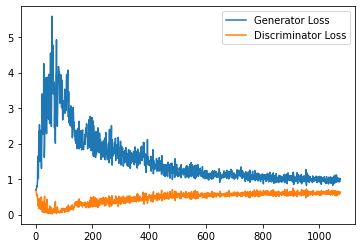

Step 22000: Generator loss: 0.9583583853244781, discriminator loss: 0.6180647086501122


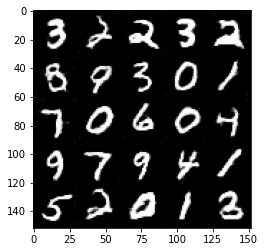

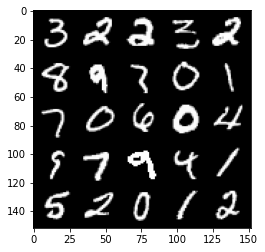

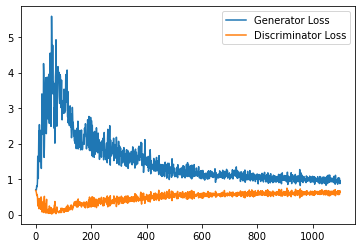

Step 22500: Generator loss: 0.95617158639431, discriminator loss: 0.6181500348448753


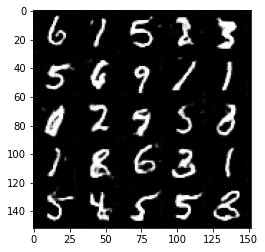

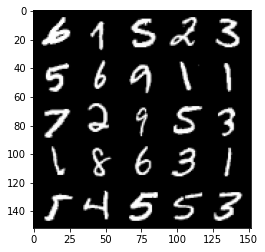

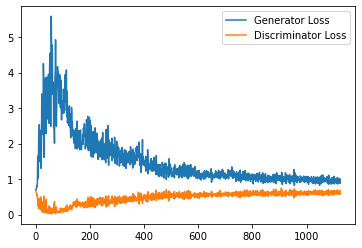

Step 23000: Generator loss: 0.9706042003631592, discriminator loss: 0.6105253345966339


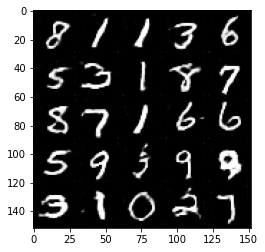

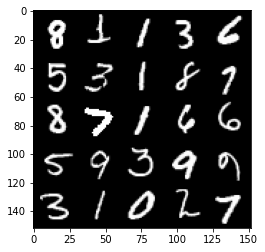

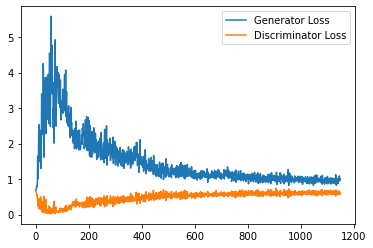

In [27]:
cur_step = 0
generator_losses = []
discriminator_losses = []

for epoch in range(n_epochs):
    
    # Dataloader returns the batches and the labels
    for real, labels in tqdm(dataloader):
        cur_batch_size = len(real)
        
        # Flatten the batch of real images from the dataset
        real = real.to(device)

        one_hot_labels = get_one_hot_labels(labels.to(device), n_classes)
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = image_one_hot_labels.repeat(1, 1, mnist_shape[1], mnist_shape[2])

        ### Update discriminator 
        # Zero out the discriminator gradients
        disc_opt.zero_grad()
        
        # Get noise corresponding to the current batch_size 
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
       
        noise_and_labels = combine_vectors(fake_noise, one_hot_labels)
        fake = gen(noise_and_labels)
      
        fake_image_and_labels = combine_vectors(fake, image_one_hot_labels)
        real_image_and_labels = combine_vectors(real, image_one_hot_labels)
        disc_fake_pred = disc(fake_image_and_labels.detach())
        disc_real_pred = disc(real_image_and_labels)
        
        
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        disc_loss.backward(retain_graph=True)
        disc_opt.step() 

        # Keep track of the average discriminator loss
        discriminator_losses += [disc_loss.item()]

        ### Update generator ###
        
        # Zero out the generator gradients
        gen_opt.zero_grad()

        fake_image_and_labels = combine_vectors(fake, image_one_hot_labels)

        disc_fake_pred = disc(fake_image_and_labels)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the generator losses
        generator_losses += [gen_loss.item()]

        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            disc_mean = sum(discriminator_losses[-display_step:]) / display_step
            print(f"Step {cur_step}: Generator loss: {gen_mean}, discriminator loss: {disc_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            x_axis = sorted([i * step_bins for i in range(len(generator_losses) // step_bins)] * step_bins)
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(discriminator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Discriminator Loss"
            )
            plt.legend()
            plt.show()
        elif cur_step == 0:
            print("Generating - Images .... ")
        cur_step += 1

In [28]:
gen = gen.eval()

### Changing the class vector

Produce intermediate images between two digits. i.e. morphing one image into another. Using conditional gan these two numbers can be chosen to generate specific results.

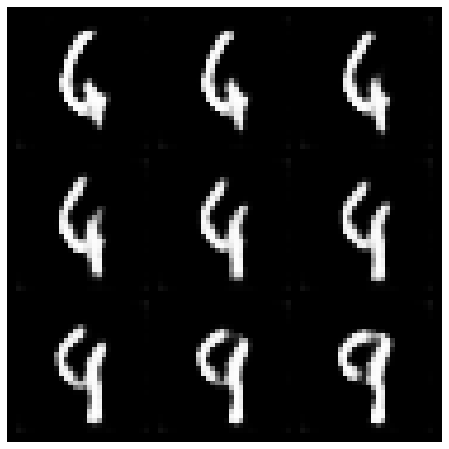

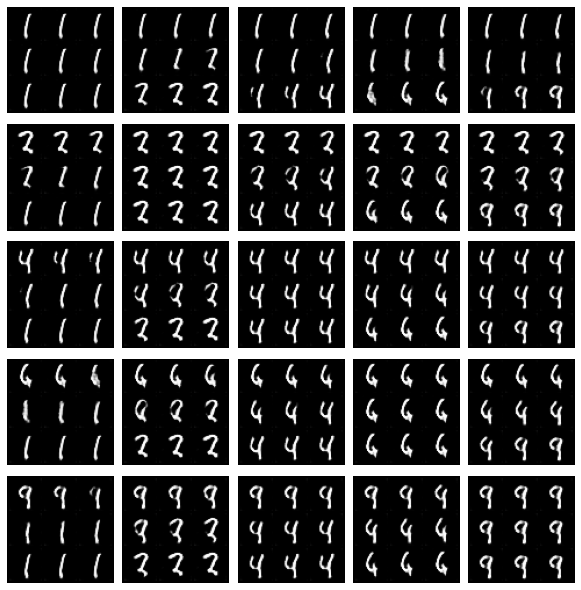

In [58]:
import math


n_interpolation = 9 # Choose the interpolation: number of intermediate images + 2 (for the start and end image)
interpolation_noise = get_noise(1, z_dim, device=device).repeat(n_interpolation, 1)

def interpolate_class(first_number, second_number):
    first_label = get_one_hot_labels(torch.Tensor([first_number]).long(), n_classes)
    second_label = get_one_hot_labels(torch.Tensor([second_number]).long(), n_classes)

    # Calculate the interpolation vector between the two labels
    percent_second_label = torch.linspace(0, 1, n_interpolation)[:, None]
    interpolation_labels = first_label * (1 - percent_second_label) + second_label * percent_second_label

    # Combine the noise and the labels
    noise_and_labels = combine_vectors(interpolation_noise, interpolation_labels.to(device))
    fake = gen(noise_and_labels)
    show_tensor_images(fake, num_images=n_interpolation, nrow=int(math.sqrt(n_interpolation)), show=False)


start_plot_number = 6 # Choose the start digit
end_plot_number = 9 # Choose the end digit

plt.figure(figsize=(8, 8))
interpolate_class(start_plot_number, end_plot_number)
_ = plt.axis('off')


### interpolations for a collection of different numbers, all in a single grid of interpolations.

plot_numbers = [1, 2, 4, 6, 9]
n_numbers = len(plot_numbers)
plt.figure(figsize=(8, 8))
for i, first_plot_number in enumerate(plot_numbers):
    for j, second_plot_number in enumerate(plot_numbers):
        plt.subplot(n_numbers, n_numbers, i * n_numbers + j + 1)
        interpolate_class(first_plot_number, second_plot_number)
        plt.axis('off')
plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.1, wspace=0)
plt.show()
plt.close()

### Changing the Noise vector

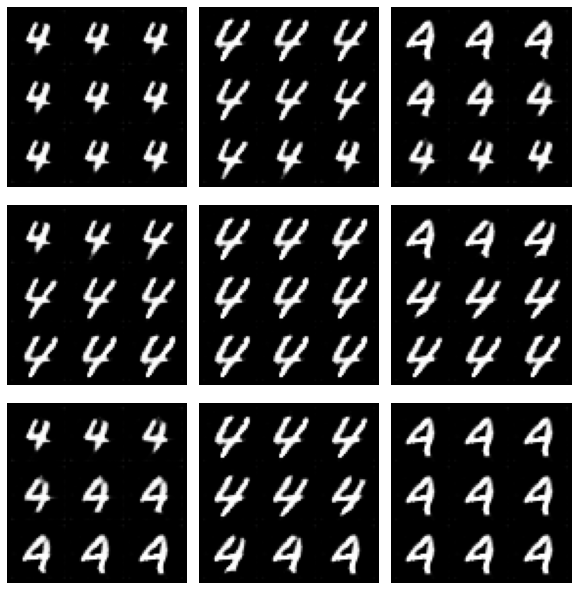

In [57]:
n_interpolation = 9 # Number of Intermediates + 2 (for the start and end image)

# Interpolating between the noise instead of the labels
interpolation_label = get_one_hot_labels(torch.Tensor([4]).long(), n_classes).repeat(n_interpolation, 1).float()

def interpolate_noise(first_noise, second_noise):
   
    percent_first_noise = torch.linspace(0, 1, n_interpolation)[:, None].to(device)
    interpolation_noise = first_noise * percent_first_noise + second_noise * (1 - percent_first_noise)

    # Combine the noise and the labels again
    noise_and_labels = combine_vectors(interpolation_noise, interpolation_label.to(device))
    fake = gen(noise_and_labels)
    show_tensor_images(fake, num_images=n_interpolation, nrow=int(math.sqrt(n_interpolation)), show=False)

# Generate noise vectors to interpolate between
n_noise = 3 # Choose the number of noise examples in the grid
plot_noises = [get_noise(1, z_dim, device=device) for i in range(n_noise)]
plt.figure(figsize=(8, 8))
for i, first_plot_noise in enumerate(plot_noises):
    for j, second_plot_noise in enumerate(plot_noises):
        plt.subplot(n_noise, n_noise, i * n_noise + j + 1)
        interpolate_noise(first_plot_noise, second_plot_noise)
        plt.axis('off')
plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.1, wspace=0)
plt.show()
plt.close()

***